In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas


Importation of Dataset 1

In [2]:
# CHOOSE DATASET

# Binary classification dataset
diabetes = datasets.load_diabetes(as_frame=True)

# Regression dataset
#data = datasets.fetch_openml(name="boston",version=1, as_frame=True) 

X = diabetes.data.values
y = diabetes.target.values

print("Shape:", X.shape)

print(diabetes.data.head(), "\n \n")# first rows of features
print(diabetes.target.head()) # first rows of target

Shape: (442, 10)
        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641   
 

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64


In [3]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [4]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


In order to be able to compare the results, the number of clusters and value of m used, was the same as the one in the previous assigment ( n_clusters = 4; m=1.1)

In [5]:
 # Number of clusters 
n_clusters = 4
m=1.1

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [6]:
centers.shape

(4, 11)

In [7]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Fuzzy partition coefficient (FPC): 0.982771992053368


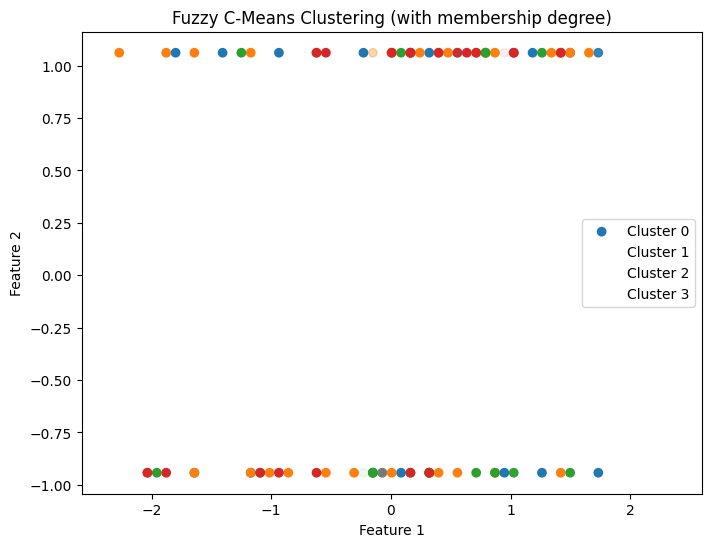

In [8]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

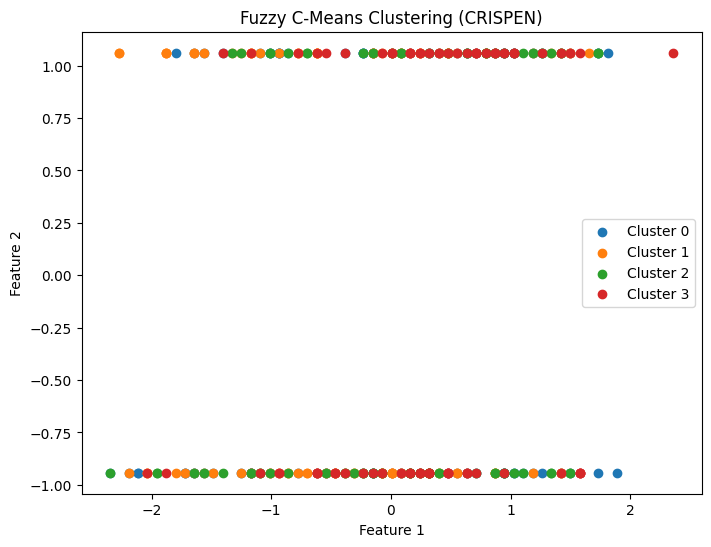

In [9]:
# Plot first two features with cluster assignments
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],
        Xexp[cluster_labels == j, 1],
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

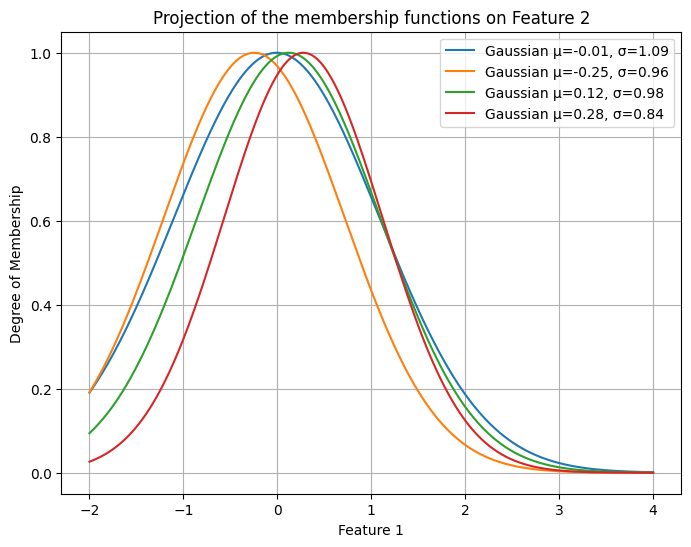

In [10]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
feature=0
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,feature], sigmas[j,feature]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,feature],2)}, σ={np.round(sigmas[j,feature],2)}")

plt.title("Projection of the membership functions on Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



In [12]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

    


In [13]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        print(loss)
        loss.backward()
        optimizer.step()


In [14]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3): #10, 20, 1e-3
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

In [15]:
# ---------------------------
# Alternative Hybrid Training (LS+ gradient descent on all)
# ---------------------------
def train_hybrid(model, X, y, epochs=100, lr=1e-5): #def; 100, 4
    # Step 1: LS for consequents
    train_ls(model, X, y)
    # Step 2: GD fine-tuning
    train_gd(model, X, y, epochs=epochs, lr=lr)


In [16]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)


In [17]:
# Training with LS:
#train_ls(model, Xtr, ytr.reshape(-1,1))
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1), max_iters=10, gd_epochs=14, lr=1e-4) #10 20 3


tensor(2382.7402, grad_fn=<MseLossBackward0>)
tensor(2382.0920, grad_fn=<MseLossBackward0>)
tensor(2381.4475, grad_fn=<MseLossBackward0>)
tensor(2380.8083, grad_fn=<MseLossBackward0>)
tensor(2380.1721, grad_fn=<MseLossBackward0>)
tensor(2379.5393, grad_fn=<MseLossBackward0>)
tensor(2378.9099, grad_fn=<MseLossBackward0>)
tensor(2378.2839, grad_fn=<MseLossBackward0>)
tensor(2377.6609, grad_fn=<MseLossBackward0>)
tensor(2377.0415, grad_fn=<MseLossBackward0>)
tensor(2376.4268, grad_fn=<MseLossBackward0>)
tensor(2375.8213, grad_fn=<MseLossBackward0>)
tensor(2375.2188, grad_fn=<MseLossBackward0>)
tensor(2374.6155, grad_fn=<MseLossBackward0>)
tensor(2373.7542, grad_fn=<MseLossBackward0>)
tensor(2373.1123, grad_fn=<MseLossBackward0>)
tensor(2372.4719, grad_fn=<MseLossBackward0>)
tensor(2371.8337, grad_fn=<MseLossBackward0>)
tensor(2371.1987, grad_fn=<MseLossBackward0>)
tensor(2370.5691, grad_fn=<MseLossBackward0>)
tensor(2369.9434, grad_fn=<MseLossBackward0>)
tensor(2369.3379, grad_fn=<MseLoss

In [18]:
y_pred, _, _=model(Xte)
#performance metric for classification
#print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification
#performance metric for regression
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

MSE:2391.4755859375


In comparison with TSK model previous used, it was possible to slightly improve the results, going from a MSE of 2476.79 to 2391.48. The change was not significative. Given the range of the target values, the MSE obtain represents a large value, not giving confidence for a certain predicted value. When visualizing the error (as ploted in the chart bellow) it is possible to notice that, bigger the value of the targer, beter it predicts it. It is possible to verify that the predicted values tend to map the trend (if the real value is bigger, the predicted one tend to be bigger as well). The problem is that it seems to be affected by a large "noise", responsible for the large MSE value obtained.

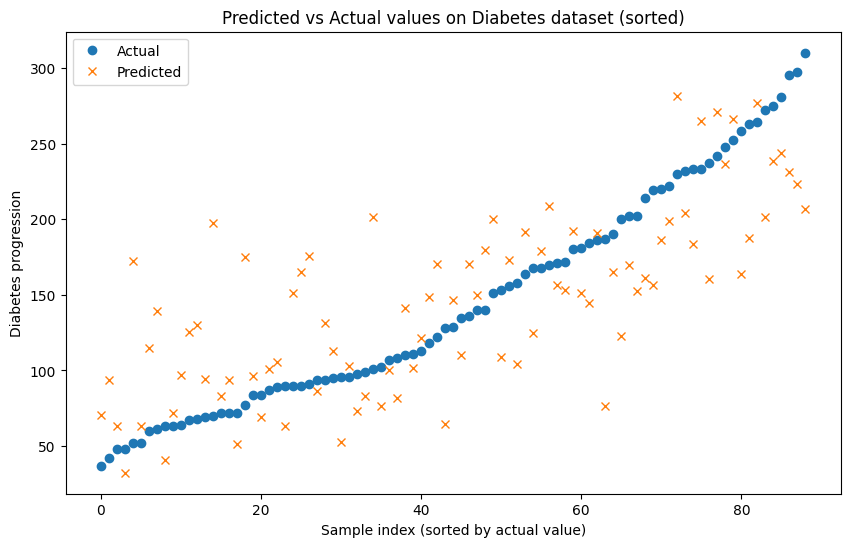

In [19]:
# Plot predictions vs actual
# Converter y_pred para numpy e flatten
y_pred_np = y_pred.detach().numpy().flatten()
yte_np = yte.detach().numpy()

# Obter índices que ordenam yte
sort_idx = np.argsort(yte_np)

# Ordenar yte e y_pred segundo esses índices
yte_sorted = yte_np[sort_idx]
y_pred_sorted = y_pred_np[sort_idx]

# Plot
plt.figure(figsize=(10,6))
plt.plot(range(len(yte_sorted)), yte_sorted, label="Actual", marker="o", linestyle='')
plt.plot(range(len(y_pred_sorted)), y_pred_sorted, label="Predicted", marker="x", linestyle='')

plt.xlabel("Sample index (sorted by actual value)")
plt.ylabel("Diabetes progression")
plt.title("Predicted vs Actual values on Diabetes dataset (sorted)")
plt.legend()
plt.show()